# Semi-structured eval: Docugami + Multi-vector retriever

We will test retrieval of table information from the `Semi-structured Reports` dataset using various methods.

## Pre-requisites

In [ ]:
%pip install --quiet -U langchain langsmith langchain_benchmarks tqdm pillow
%pip install --quiet -U chromadb openai tiktoken
%pip install --quiet -U docugami==0.0.8 dgml-utils==0.3.0

## Dataset

In [2]:
import os
from pathlib import Path

from langchain_benchmarks import registry
from langchain_benchmarks.rag.tasks.semi_structured_reports import get_file_names

# Task
task = registry["Semi-structured Reports"]

# Files used
paths = list(get_file_names())
files = [str(p) for p in paths]

### TODO: Replace when dataset is updated
#dir = "/Users/rlm/Desktop/Eval_Sets/semi_structured_reports/"
dir = "/mnt/c/Users/taqi_/OneDrive/Desktop/semi_structured_reports/"
files = [dir + f for f in os.listdir(dir) if f.endswith(".pdf")]

## Load

In [3]:
from docugami import Docugami
from docugami.lib.upload import upload_to_named_docset, wait_for_dgml

### TODO: Remove
api_key = "cukRRrDv1lwn2BnM1jiiUmjO+ptFxvg8tfmqpFRkrzlXXUtSWvTulr0ZzY5uCsQHp3doM2ZC3gcOUw+/TbzGB3FaqEcDujPRvgxy1trlhi884QAJ9GL8/AROM2KL6qYdLaelqD5IrGTteqFS9kVPhBaOxkHKYFTTkkjEkU2MOBp03JQAcfs1rt+e3t4mjz1Uf6VeBspRruvr85Jv4OMvqdsZO8qfhexyIcNeIr0Hy7jAc9dCxkvX1mKRxYf+4kPjxD6F9Pdkmf/QuQS5gc5lKKNodehADGL0hPYpbJQF+m+wnUTQYPPwb1YOQecxRx2YqwBjxY0LTyMLMWCjQggggA=="
os.environ["DOCUGAMI_API_KEY"] = api_key

# Load
DOCSET_NAME = "Semi-Structured"

dg_client = Docugami()
dg_docs = upload_to_named_docset(dg_client, files, DOCSET_NAME)
dgml_paths = wait_for_dgml(dg_client, dg_docs)
dgml_paths

{'Tax_gap.pdf': '/tmp/tmpduzbifp0',
 'MSFT_Q3_press_release.pdf': '/tmp/tmpzyvrjmev',
 'Bank_failures.pdf': '/tmp/tmpp10kghlr',
 'AMZN_Q3_press_release.pdf': '/tmp/tmp3i4lr7oc',
 'DDOG_Q3_press_release.pdf': '/tmp/tmp745oncs8',
 'GOOG_Q3_press_release.pdf': '/tmp/tmp1ijjv_aw'}

In [4]:
import hashlib
from io import BytesIO
from pathlib import Path
import requests
import tempfile
from typing import Dict, List
from langchain.schema.document import Document

from dgml_utils.models import Chunk, BoundingBox
from dgml_utils.segmentation import get_chunks_str
from docugami.types import Document as DgDocument
from PIL import Image


def download_bbox_image(dg_doc: DgDocument, bbox: BoundingBox) -> Path:
    page_image_url = dg_doc.url + f"/pages/{bbox.page}/content"

    # Download the full page image
    response = requests.get(url=page_image_url, headers=dg_client.auth_headers)
    if not response.ok:
        raise ValueError(f"Failed to download page image: {page_image_url}")

    # Crop and save only the given bbox inside the full page image
    image = Image.open(BytesIO(response.content))
    cropped_image = image.crop(
        (bbox.left, bbox.top, bbox.left + bbox.width, bbox.top + bbox.height)
    )
    temp_file = tempfile.NamedTemporaryFile(suffix=".jpg", delete=False)
    cropped_image.save(temp_file.name, format="JPEG")

    return Path(temp_file.name)


def extract_docugami_file(dg_doc: DgDocument, dgml_path: Path):
    print(f"Processing file: {dgml_path}")
    chunks: List[Chunk] = []
    with open(dgml_path, "r") as file:
        contents = file.read().encode("utf-8")

        # Chars to OpenAI token math ref:
        # https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
        chunks = get_chunks_str(
            contents,
            min_text_length=256,
            parent_hierarchy_levels=1000,  # parent nodes will effectively be the entire doc
            max_text_length=1024 * 128,  # max len for chunk or parent ~32k tokens
            include_xml_tags=True,
            sub_chunk_tables=False,
        )

    # Build maps of elements and parents
    text_chunks_by_id: Dict[str, Document] = {}
    full_docs_by_id: Dict[str, Document] = {}
    table_chunks_by_id: Dict[str, Document] = {}
    table_image_paths: List[Path] = []
    for chunk in chunks:
        chunk_id = hashlib.md5(chunk.text.encode()).hexdigest()
        is_table = "table" in chunk.structure.split()
        meta = {"id": chunk_id, "source": dg_doc.name}

        parent_chunk = chunk.parent
        if parent_chunk:
            # per the docugami loader settings, parent chunks are the entire (full) docs
            parent_chunk_id = hashlib.md5(parent_chunk.text.encode()).hexdigest()
            full_docs_by_id[parent_chunk_id] = Document(
                page_content=parent_chunk.text,
                metadata={"id": parent_chunk_id, "source": dg_doc.name},
            )
            meta.update({"full_doc_id": parent_chunk_id})

        if is_table:
            table_chunks_by_id[chunk_id] = Document(
                page_content=chunk.text,
                metadata=meta,
            )
            for bbox in chunk.bboxes:
                table_image_paths.append(download_bbox_image(dg_doc, bbox))
        else:
            text_chunks_by_id[chunk_id] = Document(
                page_content=chunk.text,
                metadata=meta,
            )

    print(
        f"There are {len(table_chunks_by_id)} table elements in {len(full_docs_by_id)} full docs"
    )
    print(
        f"There are {len(table_image_paths)} table images in {len(full_docs_by_id)} full docs"
    )
    print(
        f"There are {len(text_chunks_by_id)} text elements in {len(full_docs_by_id)} full docs"
    )

    return (
        full_docs_by_id,
        text_chunks_by_id,
        table_chunks_by_id,
        table_image_paths,
    )


docugami_full_docs_by_id: Dict[str, Document] = {}
docugami_text_chunks_by_id: Dict[str, Document] = {}
docugami_table_chunks_by_id: Dict[str, Document] = {}
docugami_table_image_paths: List[Path] = []
for fname in files:
    # Get xml
    f_name = Path(fname).name
    dgml_path = dgml_paths[f_name]
    dg_doc = [d for d in dg_docs if d.name == f_name][0]

    # Extract elements
    (
        full_docs_by_id,
        text_chunks_by_id,
        table_chunks_by_id,
        table_image_paths,
    ) = extract_docugami_file(dg_doc, dgml_path)

    docugami_full_docs_by_id.update(full_docs_by_id)
    docugami_text_chunks_by_id.update(text_chunks_by_id)
    docugami_table_chunks_by_id.update(table_chunks_by_id)
    docugami_table_image_paths += table_image_paths

Processing file: /tmp/tmp3i4lr7oc
There are 9 table elements in 1 full docs
There are 9 table images in 1 full docs
There are 86 text elements in 1 full docs
Processing file: /tmp/tmpp10kghlr
There are 1 table elements in 1 full docs
There are 1 table images in 1 full docs
There are 26 text elements in 1 full docs
Processing file: /tmp/tmp745oncs8
There are 6 table elements in 1 full docs
There are 6 table images in 1 full docs
There are 35 text elements in 1 full docs
Processing file: /tmp/tmp1ijjv_aw
There are 13 table elements in 1 full docs
There are 13 table images in 1 full docs
There are 30 text elements in 1 full docs
Processing file: /tmp/tmpzyvrjmev
There are 12 table elements in 1 full docs
There are 13 table images in 1 full docs
There are 37 text elements in 1 full docs
Processing file: /tmp/tmpduzbifp0
There are 3 table elements in 1 full docs
There are 3 table images in 1 full docs
There are 23 text elements in 1 full docs


## Index

### Text

In [5]:
from typing import Optional
import uuid
from tqdm import tqdm

from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.prompts import ChatPromptTemplate
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.document import Document
from langchain.schema.output_parser import StrOutputParser
from langchain.storage import InMemoryStore
from langchain.vectorstores import Chroma

from langchain.cache import SQLiteCache
from langchain.globals import set_llm_cache

set_llm_cache(SQLiteCache(database_path="/tmp/.langchain.db"))

LLM = ChatOpenAI(temperature=0, model="gpt-4-1106-preview")


def generate_summaries(
    docs_by_id: Dict[str, Document],
    parent_id_key="doc_id",
    summarize_length_threshold=2048,
) -> Dict[str, Document]:
    """
    Summarize text chunks

    docs_by_id: map of doc id to chunk (Document)
    parent_id_key: metadata key to associate summarized document with original document
    summarize_length_threshold: summarize only texts that are greater than this threshold

    Returns map of doc id to summarized document. The
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # Text summary chain
    summarize_chain = {"element": lambda x: x} | prompt | LLM | StrOutputParser()

    # Initialize empty response
    summarized_docs: Dict[str, Document] = {}

    # Summarize documents that are greater than length threshold
    for doc_id in tqdm(docs_by_id):
        doc = docs_by_id[doc_id].copy(deep=True)
        if len(doc.page_content) > summarize_length_threshold:
            # summarize only if above length threshold
            doc.page_content = summarize_chain.invoke(doc.page_content)
            summarized_doc_id = hashlib.md5(doc.page_content.encode()).hexdigest()
            doc.metadata["id"] = summarized_doc_id

        doc.metadata[parent_id_key] = doc_id
        summarized_docs[doc_id] = doc

    return summarized_docs


def create_multi_vector_retriever(
    vectorstore,
    text_summaries_by_id: Optional[Dict[str, Document]] = None,
    text_docs_by_id: Optional[Dict[str, Document]] = None,
    table_summaries_by_id: Optional[Dict[str, Document]] = None,
    table_docs_by_id: Optional[Dict[str, Document]] = None,
    image_summaries: Optional[List[str]] = None,
    images: Optional[List[str]] = None,
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Add texts if specified
    if text_summaries_by_id and text_docs_by_id:
        assert len(text_summaries_by_id) == len(text_docs_by_id)
        retriever.vectorstore.add_documents(text_summaries_by_id.values())
        retriever.docstore.mset(text_docs_by_id.items())

    # Add tables if specified
    if table_summaries_by_id and table_docs_by_id:
        assert len(table_summaries_by_id) == len(table_docs_by_id)
        retriever.vectorstore.add_documents(table_summaries_by_id.values())
        retriever.docstore.mset(table_docs_by_id.items())

    # Add images if specified
    if image_summaries and images:
        assert len(image_summaries) == len(images)
        image_doc_ids = [str(uuid.uuid4()) for _ in images]
        image_summary_docs = [
            Document(page_content=s, metadata={id_key: image_doc_ids[i]})
            for i, s in enumerate(image_summaries)
        ]
        retriever.vectorstore.add_documents(image_summary_docs)
        retriever.docstore.mset(list(zip(image_doc_ids, images)))

    return retriever

In [6]:
# Get text, table summaries
docugami_text_summaries_by_id = generate_summaries(docugami_text_chunks_by_id)
docugami_table_summaries_by_id = generate_summaries(docugami_table_chunks_by_id)

# The vectorstore to use to index the summaries
docugami_chunk_summaries_vectorstore = Chroma(
    collection_name="docugami_chunk_summaries", embedding_function=OpenAIEmbeddings()
)

# Create retriever
retriever_docugami_chunk_summaries = create_multi_vector_retriever(
    docugami_chunk_summaries_vectorstore,
    text_summaries_by_id=docugami_text_summaries_by_id,
    text_docs_by_id=docugami_text_chunks_by_id,
    table_summaries_by_id=docugami_table_summaries_by_id,
    table_docs_by_id=docugami_table_chunks_by_id,
)

100%|██████████| 44/44 [00:00<00:00, 248.60it/s]


### Images

In [7]:
import base64
from typing import List

from langchain.schema.messages import HumanMessage


def encode_image(image_path: Path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64: str, prompt: str):
    """Make image summary"""
    chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024)

    try:
        msg = chat.invoke(
            [
                HumanMessage(
                    content=[
                        {"type": "text", "text": prompt},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{img_base64}"
                            },
                        },
                    ]
                )
            ]
        )
        return msg.content
    except:
        print("Failure")
        return "No summary"


def generate_img_summaries(paths: List[Path]):
    """
    Generate summaries and base64 encoded strings for images
    paths: List of image file paths (JPEG)
    """

    # Store base64 encoded images
    img_base64_list: List[str] = []

    # Store image summaries
    image_summaries: List[str] = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in paths:
        if img_file.suffix.lower() in [".jpg", ".jpeg"]:
            file_size = os.path.getsize(img_file)

            # Minimum file size threshold (25 KB)
            min_file_size = 25 * 1024  # 25 KB in bytes (filter erroneous crops)
            if file_size > min_file_size:
                base64_image = encode_image(img_file)
                img_base64_list.append(base64_image)
                image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries

In [8]:
# Image summaries
(
    docugami_table_image_base64_list,
    docugami_table_image_summaries,
) = generate_img_summaries(docugami_table_image_paths)

In [9]:
# The vectorstore to use to index the summaries
docugami_chunk_and_img_summaries_vectorstore = Chroma(
    collection_name="docugami_chunk_and_img_summaries", embedding_function=OpenAIEmbeddings()
)

retriever_docugami_chunk_and_img_summaries = create_multi_vector_retriever(
    docugami_chunk_and_img_summaries_vectorstore,
    text_summaries_by_id=docugami_text_summaries_by_id,
    text_docs_by_id=docugami_text_chunks_by_id,
    image_summaries=docugami_table_image_summaries,
    images=docugami_table_image_base64_list,
)

## RAG

In [10]:
datadog_deferred_revenue_query = "What was Datadog's total deferred revenue as of September 30, 2023?"
operating_expenses_query = "Analyzing the operating expenses for Q3 2023, which category saw the largest increase when compared to Q3 2022?"

### Text

In [11]:
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough

def format_context_documents(docs: List[Document]) -> str:
    return "\n\n".join([i.page_content for i in docs])

def rag_chain(retriever):
    """
    RAG chain
    """

    # Prompt template
    template = """Answer the question based only on the following context, which can include text and tables:
    {context}
    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(format_context_documents),
            "question": RunnablePassthrough(),
        }
        | prompt
        | LLM
        | StrOutputParser()
    )
    return chain


# Create chain
chain_docugami_chunk_summaries = rag_chain(retriever_docugami_chunk_summaries)

In [12]:
# Test the chain    
answer = chain_docugami_chunk_summaries.invoke(datadog_deferred_revenue_query)

print(answer)

The provided context does not include information about Datadog's total deferred revenue as of September 30, 2023. To find this information, one would typically refer to the financial statements or earnings report released by the company, which should be publicly available through their investor relations website or financial disclosures filed with the Securities and Exchange Commission (SEC). Since this specific detail is not included in the context given, I am unable to provide the total deferred revenue for Datadog as of that date.


In [13]:
# Test the chain
answer = chain_docugami_chunk_summaries.invoke(operating_expenses_query)

print(answer)

To determine which category of operating expenses saw the largest increase in Q3 2023 compared to Q3 2022, we need to look at the year-over-year (Y/Y) percentage change for each category provided in the tables. The categories listed under operating expenses are:

1. Cost of sales
2. Fulfillment
3. Technology and infrastructure
4. Sales and marketing
5. General and administrative
6. Total stock-based compensation expense

For each of these categories, we will look at the Y/Y % Change column for Q3 2023:

1. Cost of sales: 2%
2. Fulfillment: 1%
3. Technology and infrastructure: 8%
4. Sales and marketing: (-2%)
5. General and administrative: 7%
6. Total stock-based compensation expense: 5%

Based on the Y/Y % Change provided, the category that saw the largest increase in Q3 2023 compared to Q3 2022 is "Technology and infrastructure," with an 8% increase.


### Images

In [14]:
import io
import re

from IPython.display import HTML, display
from langchain.schema.runnable import RunnableLambda
from PIL import Image


def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content

        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append("\n\n" + doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are an analyst tasking with providing advice based on images.\n"
            "You may be given a mix of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide analysis related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


chain_docugami_chunk_and_image_summaries = multi_modal_rag_chain(retriever_docugami_chunk_and_img_summaries)

Let's test the retriever


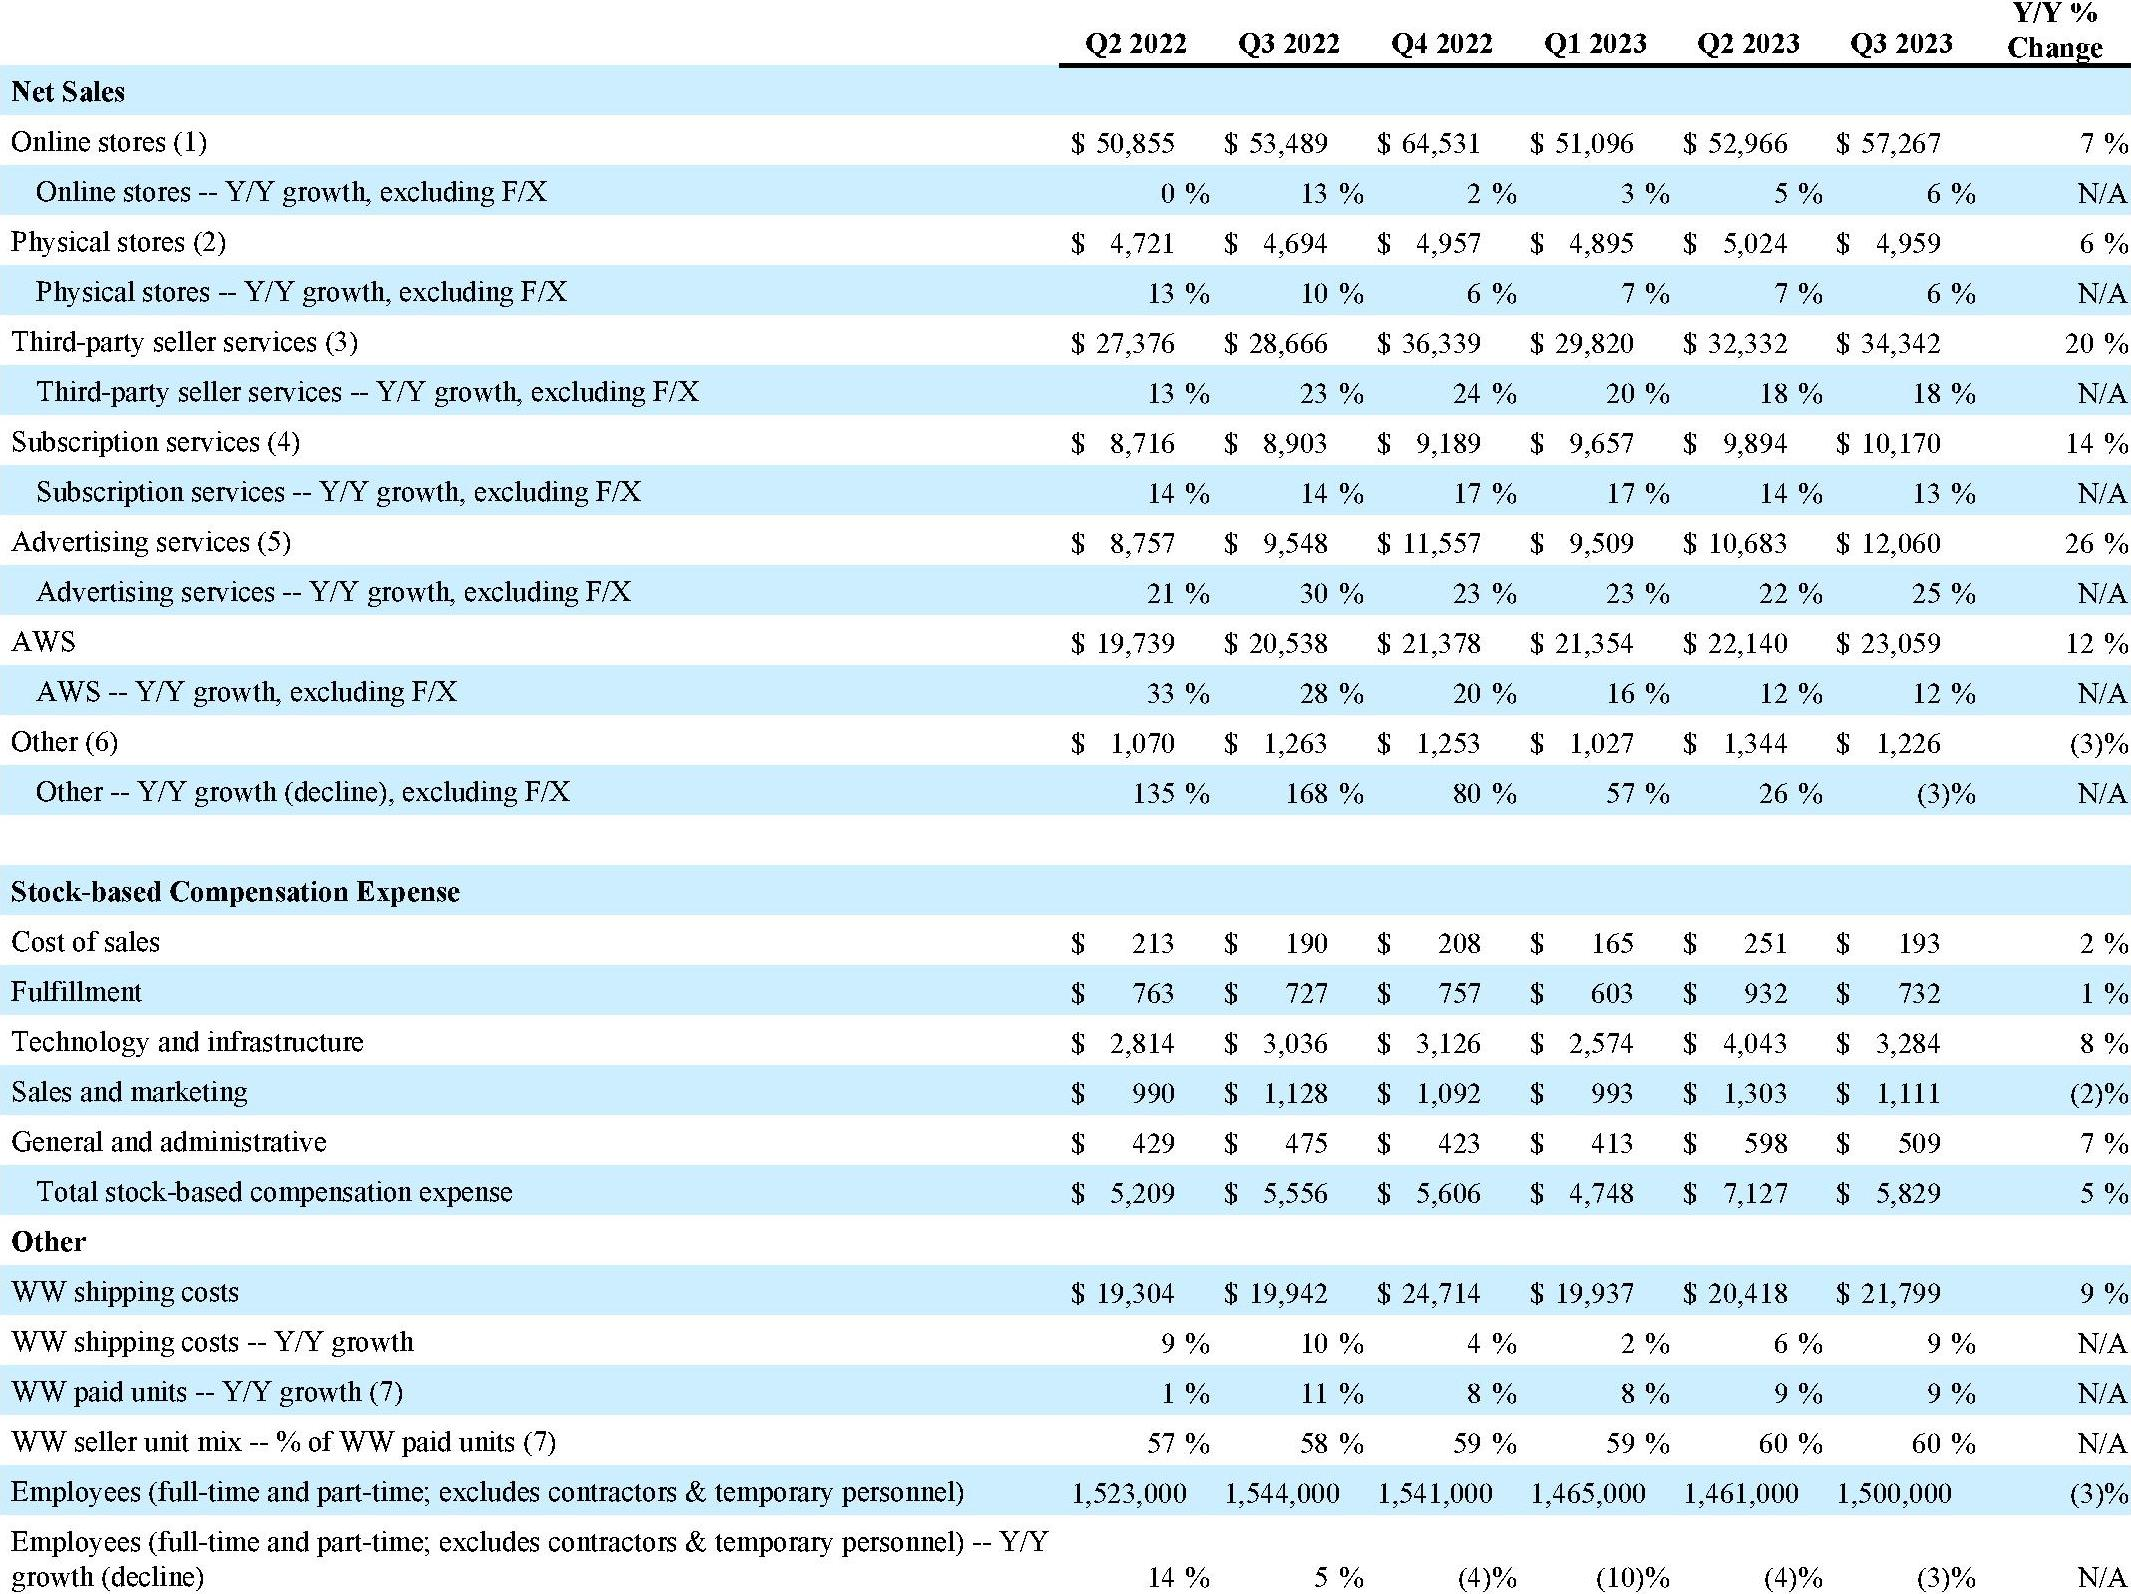

In [15]:
# Check retrieval
docs = retriever_docugami_chunk_and_img_summaries.get_relevant_documents(operating_expenses_query, limit=6)

# Check that we get back relevant images
plt_img_base64(docs[0])

In [16]:
# Test the chain
answer = chain_docugami_chunk_and_image_summaries.invoke(datadog_deferred_revenue_query)

print(answer)

Based on the provided information, there is no specific data regarding Datadog's total deferred revenue as of September 30, 2023. The text provided is a general outlook and forward-looking statements for the company's financial performance and does not include actual figures for deferred revenue. To obtain this information, one would need to refer to Datadog's Quarterly Report on Form 10-Q for the quarter ended September 30, 2023, which is mentioned in the text as a source for additional information. This report would typically be filed with the Securities and Exchange Commission (SEC) and would contain detailed financial statements, including the total deferred revenue.


In [17]:
# Test the chain
answer = chain_docugami_chunk_and_image_summaries.invoke(operating_expenses_query)

print(answer)

To analyze the operating expenses for Q3 2023 and compare them to Q3 2022, we need to look at the categories listed in the provided financial tables and identify the category with the largest year-over-year percentage increase.

From the first image, we can see various categories of net sales and operating expenses. The "Year-over-Year % Change" column for Q3 2023 provides the percentage increase or decrease compared to Q3 2022. Here are the categories with notable changes:

- Online stores (1): 6% increase
- Physical stores (2): 6% increase
- Third-party seller services (3): 20% increase
- Subscription services (4): 13% increase
- Advertising services (5): N/A (not applicable or not available)
- AWS: 12% increase
- Other (6): (3)% decrease
- Stock-based Compensation Expense: 2% increase
- Cost of sales: 20% increase
- Technology and infrastructure: 8% increase
- Sales and marketing: 20% increase
- General and administrative: 20% increase
- Total stock-based compensation expense: 2% in

### Fused Summary Retriever

Let's try a different retrieval technique that is similar to the Multi-Vector retriever, but additionally fuses the summary of each (full) document with retrieved chunks to give the LLM broader context than what is found in the actual retrieved chunks.

In [18]:
from fused_summary_retriever import FusedSummaryRetriever, SearchType


def create_fused_summary_retriever(
    vectorstore,
    full_doc_summaries_by_id: Dict[str, str],
    text_summaries_by_id: Optional[Dict[str, Document]] = None,
    text_docs_by_id: Optional[Dict[str, Document]] = None,
    table_summaries_by_id: Optional[Dict[str, Document]] = None,
    table_docs_by_id: Optional[Dict[str, Document]] = None,
):
    """
    Create retriever that indexes summaries, but returns raw texts
    in addition to the associated full-document summary for broader context
    """

    # Initialize the storage layer
    parent_doc_store = InMemoryStore()
    parent_id_key = "doc_id"

    full_doc_summary_store = InMemoryStore()
    full_doc_id_key = "full_doc_id"
    full_doc_summary_store.mset(full_doc_summaries_by_id.items())

    # Create the fused summary retriever
    retriever = FusedSummaryRetriever(
        vectorstore=vectorstore,
        parent_doc_store=parent_doc_store,
        parent_id_key=parent_id_key,
        full_doc_summary_store=full_doc_summary_store,
        full_doc_summary_id_key=full_doc_id_key,
        search_kwargs={"k": 20},
        search_type=SearchType.mmr,
    )

    # Add texts if specified
    if text_summaries_by_id and text_docs_by_id:
        assert len(text_summaries_by_id) == len(text_docs_by_id)
        retriever.vectorstore.add_documents(text_summaries_by_id.values())
        retriever.parent_doc_store.mset(text_docs_by_id.items())

    # Add tables if specified
    if table_summaries_by_id and table_docs_by_id:
        assert len(table_summaries_by_id) == len(table_docs_by_id)
        retriever.vectorstore.add_documents(table_summaries_by_id.values())
        retriever.parent_doc_store.mset(table_docs_by_id.items())

    return retriever

Let's create summaries of the parent documents returned by Docugami, and create a chain around our fused summary retriever.

In [19]:
from tqdm import tqdm

BATCH_SIZE = 5
LARGE_FRAGMENT_MAX_TEXT_LENGTH = 1024 * 20

ASSISTANT_SYSTEM_MESSAGE = """You are a helpful assistant that answers user queries using available context.

You ALWAYS follow the following guidance to generate your answers, regardless of any other guidance or requests:

- Use professional language typically used in business communication.
- Strive to be accurate and cite where you got your answer in the given context documents.
- Generate only the requested answer, no other language or separators before or after.

All your answers must contain citations to help the user understand how you created the citation, specifically:

- If the given context contains the names of document(s), make sure you include that in your answer as 
  a citation, e.g. include "\\n\\nSOURCE(S): foo.pdf, bar.pdf" at the end of your answer.
- Make sure there an actual answer if you show a SOURCE citation, i.e. make sure you don't show only
  a bare citation with no actual answer. 
"""

CREATE_FULL_DOCUMENT_SUMMARY_PROMPT = """Here is a document, in {format} format:

{doc_fragment}

Please write a detailed summary of the given document.

Keep in mind the following rules:

- Your generated summary should be in the same format as the given document, using the same overall schema.
- The generated summary should be up to 2 pages of text in length, shorter if the original document is short.
- Only summarize, don't try to change any facts in the document even if they appear incorrect to you
- Include as many facts and data points from the original document as you can, in your summary.

Respond only with the detailed summary and no other language before or after.
"""


def build_full_doc_summary_mappings(
    docs_by_id: Dict[str, str], xml=False
) -> Dict[str, str]:
    # build summaries for all the given documents

    summaries: Dict[str, str] = {}
    format = "text" if not xml else "semantic XML without any namespaces or attributes"

    # Splitting the documents into batches
    doc_items = list(docs_by_id.items())
    for i in tqdm(
        range(0, len(doc_items), BATCH_SIZE),
        "Creating full document summaries in batches",
    ):
        batch = doc_items[i : i + BATCH_SIZE]

        # Preparing batch input
        batch_input = [
            {
                "format": format,
                "doc_fragment": doc.page_content[:LARGE_FRAGMENT_MAX_TEXT_LENGTH],
            }
            for _, doc in batch
        ]

        # Processing the batch
        chain = (
            ChatPromptTemplate.from_messages(
                [
                    ("system", ASSISTANT_SYSTEM_MESSAGE),
                    ("human", CREATE_FULL_DOCUMENT_SUMMARY_PROMPT),
                ]
            )
            | LLM
            | StrOutputParser()
        )
        batch_summaries = chain.batch(batch_input)

        # Assigning summaries to the respective document IDs
        for (id, _), summary in zip(batch, batch_summaries):
            summaries[id] = summary

    return summaries


doc_summaries_by_id = build_full_doc_summary_mappings(docugami_full_docs_by_id)

Creating full document summaries in batches: 100%|██████████| 2/2 [00:00<00:00, 48.53it/s]


In [20]:
fused_summaries_vectorstore = Chroma(
    collection_name="fused_summaries", embedding_function=OpenAIEmbeddings()
)


retriever_docugami_fused_summaries = create_fused_summary_retriever(
    fused_summaries_vectorstore,
    full_doc_summaries_by_id=doc_summaries_by_id,
    text_summaries_by_id=docugami_text_summaries_by_id,
    text_docs_by_id=docugami_text_chunks_by_id,
    table_summaries_by_id=docugami_table_summaries_by_id,
    table_docs_by_id=docugami_table_chunks_by_id,
)

# Create Fused Summaries RAG chain
prompt = """Answer the question based only on the following context, which can include text and tables:

{context}

Question: {question}
"""

chain_docugami_fused_summaries = (
    {
        "context": retriever_docugami_fused_summaries
        | RunnableLambda(format_context_documents),
        "question": RunnablePassthrough(),
    }
    | ChatPromptTemplate.from_messages(
        [
            ("system", ASSISTANT_SYSTEM_MESSAGE),
            ("human", prompt),
        ]
    )
    | LLM
    | StrOutputParser()
)

In [21]:
# Test the chain
answer = chain_docugami_fused_summaries.invoke(datadog_deferred_revenue_query)

print(answer)

Datadog's total deferred revenue as of September 30, 2023, was $654.0 million, which is the sum of the current deferred revenue of $636.5 million and the non-current deferred revenue of $17.5 million.

SOURCE(S): DDOG_Q3_press_release.pdf


In [22]:
# Test the chain
answer = chain_docugami_fused_summaries.invoke(operating_expenses_query)

print(answer)

The category that saw the largest increase in operating expenses for Q3 2023 when compared to Q3 2022 was "Research and development" for Datadog, Inc. The expenses increased from $205,388 thousand in Q3 2022 to $240,225 thousand in Q3 2023.

SOURCE(S): DDOG_Q3_press_release.pdf


## Eval

In [23]:
from langsmith.client import Client
from langchain.smith import RunEvalConfig
from langchain_benchmarks.rag import get_eval_config

eval_config = RunEvalConfig(
    evaluators=["cot_qa"],
)

def run_eval(chain, eval_run_name):
    """
    Run eval
    """
    client = Client()
    test_run = client.run_on_dataset(
        ### TODO: Replace with public dataset
        dataset_name="Semi-Structured-Eval-v5",
        llm_or_chain_factory=lambda: (lambda x: x["question"]) | chain,
        evaluation=eval_config,
        verbose=True,
        project_name=eval_run_name,
    )


# Experiments
chain_map = {
    "docugami-chunk-summaries": chain_docugami_chunk_summaries,
    "docugami-chunk-and-image-summaries": chain_docugami_chunk_and_image_summaries,
    "docugami-fused-summaries": chain_docugami_fused_summaries,
}

run_id = str(uuid.uuid4())
for project_name, chain in chain_map.items():
    run_eval(chain, project_name + "_" + run_id)

View the evaluation results for project 'docugami-chunk-summaries_aec9656d-fdc3-4d72-ae34-7d435181a379' at:
https://smith.langchain.com/o/530c4d06-5640-4c0f-94fe-0be7b769531f/datasets/a89c07d6-a467-414e-9349-8e49870c99bb/compare?selectedSessions=d3e65093-d657-4dcc-aadc-23d6d46c18fe

View all tests for Dataset Semi-Structured-Eval-v5 at:
https://smith.langchain.com/o/530c4d06-5640-4c0f-94fe-0be7b769531f/datasets/a89c07d6-a467-414e-9349-8e49870c99bb
[------------------------------------------------->] 25/25

,output,feedback.COT Contextual Accuracy,error,execution_time
count,25,25.0,0,25.000000
unique,25,NaN,0,NaN
top,Datadog's Non-GAAP gross margin for the Nine M...,NaN,NaN,NaN
freq,1,NaN,NaN,NaN
mean,NaN,0.4,NaN,4.349809
std,NaN,0.5,NaN,5.157432
min,NaN,0.0,NaN,1.835337
25%,NaN,0.0,NaN,1.979019
50%,NaN,0.0,NaN,2.309319
75%,NaN,1.0,NaN,3.160853


View the evaluation results for project 'docugami-chunk-and-image-summaries_aec9656d-fdc3-4d72-ae34-7d435181a379' at:
https://smith.langchain.com/o/530c4d06-5640-4c0f-94fe-0be7b769531f/datasets/a89c07d6-a467-414e-9349-8e49870c99bb/compare?selectedSessions=af05d75a-3223-4296-9e21-3db433348dfb

View all tests for Dataset Semi-Structured-Eval-v5 at:
https://smith.langchain.com/o/530c4d06-5640-4c0f-94fe-0be7b769531f/datasets/a89c07d6-a467-414e-9349-8e49870c99bb
[------------------->                              ] 10/25

Connection error caused failure to post https://api.smith.langchain.com/runs  in LangSmith API. Please confirm your LANGCHAIN_ENDPOINT. ConnectionError(MaxRetryError('HTTPSConnectionPool(host=\'api.smith.langchain.com\', port=443): Max retries exceeded with url: /runs (Caused by ReadTimeoutError("HTTPSConnectionPool(host=\'api.smith.langchain.com\', port=443): Read timed out. (read timeout=7.0)"))'))
Connection error caused failure to patch https://api.smith.langchain.com/runs/010b6356-f41f-4039-bf91-ddf4706f144c  in LangSmith API. Please confirm your LANGCHAIN_ENDPOINT. ConnectionError(MaxRetryError('HTTPSConnectionPool(host=\'api.smith.langchain.com\', port=443): Max retries exceeded with url: /runs/010b6356-f41f-4039-bf91-ddf4706f144c (Caused by ReadTimeoutError("HTTPSConnectionPool(host=\'api.smith.langchain.com\', port=443): Read timed out. (read timeout=7.0)"))'))


[------------------------------------------------->] 25/25

,output,feedback.COT Contextual Accuracy,error,execution_time
count,25,25.000000,0,25.000000
unique,25,NaN,0,NaN
top,Based on the provided image of the financial t...,NaN,NaN,NaN
freq,1,NaN,NaN,NaN
mean,NaN,0.520000,NaN,18.614745
std,NaN,0.509902,NaN,10.493011
min,NaN,0.000000,NaN,2.526053
25%,NaN,0.000000,NaN,10.760192
50%,NaN,1.000000,NaN,20.055030
75%,NaN,1.000000,NaN,27.957564


View the evaluation results for project 'docugami-fused-summaries_aec9656d-fdc3-4d72-ae34-7d435181a379' at:
https://smith.langchain.com/o/530c4d06-5640-4c0f-94fe-0be7b769531f/datasets/a89c07d6-a467-414e-9349-8e49870c99bb/compare?selectedSessions=50444e5a-0820-4905-90ff-5a8b1a5ac565

View all tests for Dataset Semi-Structured-Eval-v5 at:
https://smith.langchain.com/o/530c4d06-5640-4c0f-94fe-0be7b769531f/datasets/a89c07d6-a467-414e-9349-8e49870c99bb
[------------------------------------------------->] 25/25

,output,feedback.COT Contextual Accuracy,error,execution_time
count,25,25.000000,0,25.000000
unique,25,NaN,0,NaN
top,Datadog's Non-GAAP gross margin for the Nine M...,NaN,NaN,NaN
freq,1,NaN,NaN,NaN
mean,NaN,0.720000,NaN,12.524820
std,NaN,0.458258,NaN,7.221337
min,NaN,0.000000,NaN,2.252049
25%,NaN,0.000000,NaN,4.051698
50%,NaN,1.000000,NaN,13.593566
75%,NaN,1.000000,NaN,16.154405
